# Mental Health in the Tech Industry

## 1. Introduction

Mental health is a critical component of overall well-being. This analysis seeks to leverage a dataset (https://www.kaggle.com/datasets/anth7310/mental-health-in-the-tech-industry) from Kaggle to better understand the sociodemographic features of survey respondents and their mental health experiences.

**Business aim: To identify the most prevalent mental health conditions within the tech industry and determine their prevalence rates, focusing on identifying the country or countries as targets for calculating these rates.**

The final loaded dataset contains the following features:

**year** - Specifies the year the survey was conducted (e.g., 2014, 2016, 2017, 2018, 2019).

**survey** - Indicates the specific survey from which the data was collected.

**question_id** - An identifier for each question in the survey.

**question_text** - The full text of the question asked in the survey.

**user_id** - An identifier for each respondent participating in the survey.

**answer_text** - The respondent's answer to the corresponding survey question.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, spearmanr
from mental_health_utils import *

In [2]:
pd.set_option("display.max_colwidth", 200)

In [3]:
custom_palette = sns.color_palette(["#E69F00", "#56B4E9", "#009E73"])
sns.set_palette(custom_palette)

## 2. Data Loading & Checking

**Joining tables into the final dataset.**

In [4]:
db_path = "dataset/mental_health.sqlite"
mental_df = join_tables_to_dataframe(db_path)

In [5]:
mental_df.head()

,year,survey,question_id,question_text,user_id,answer_text
0,2014,mental health survey for 2014,1,What is your age?,1,37
1,2014,mental health survey for 2014,1,What is your age?,2,44
2,2014,mental health survey for 2014,1,What is your age?,3,32
3,2014,mental health survey for 2014,1,What is your age?,4,31
4,2014,mental health survey for 2014,1,What is your age?,5,31


**Checking for NaN values.**

In [6]:
missing_values_counts = mental_df.isna().sum()
print(f"How many NaN values:", sum(missing_values_counts))

How many NaN values: 0


**However, about a quarter (56598/236898) of the answers have a value of -1, which indicates 'Not Applicable', 'Missing value' or 'Error' depending on the survey question:**

In [7]:
mental_df.describe(include=["object"]).T

,count,unique,top,freq
survey,236898,5,mental health survey for 2016,88238
question_text,236898,105,What is your age?,4218
answer_text,236898,4215,-1,56598


**For example, the survey question 'If you live in the United States, which state or territory do you live in?' implies that some answers may have 'Not Applicable' values (value of -1 in dataset).**

In [8]:
united_states_df = mental_df[
    mental_df["question_text"]
    == "If you live in the United States, which state or territory do you live in?"
]

count_negative_1 = (united_states_df["answer_text"] == "-1").sum()
print("Count of -1 values:", count_negative_1)

Count of -1 values: 1622


**An example of a 'Missing value' or 'Error' case, because the age (question 'What is your age?') cannot be negative:**

In [9]:
age_df = mental_df[mental_df["question_text"] == "What is your age?"].copy()
age_df["answer_text"] = pd.to_numeric(age_df["answer_text"])
distinct_values = age_df["answer_text"].value_counts()

if -1 in distinct_values.index:
    count_negative_1 = distinct_values.loc[-1]
else:
    count_negative_1 = 0

print("Count of -1 values:", count_negative_1)

Count of -1 values: 5


**In the EDA part, -1 values will be treated based on the specific survey question.**

**Checking for any duplicate rows.**

In [10]:
duplicated_rows_count = mental_df.duplicated().sum()
print(f"How many duplicate rows:", sum(missing_values_counts))

How many duplicate rows: 0


## 3. Overview of the Respondents of the Survey

### 3.1 What is the sample size?

In [11]:
unique_respondents = mental_df["user_id"].nunique()
print(f"Sample size is: {unique_respondents}")

Sample size is: 4218


**Grouping the number of the respondents by year.**

In [12]:
respondents_df = (
    mental_df.groupby("year").agg(respondents=("user_id", "nunique")).reset_index()
)

**Plotting result.**

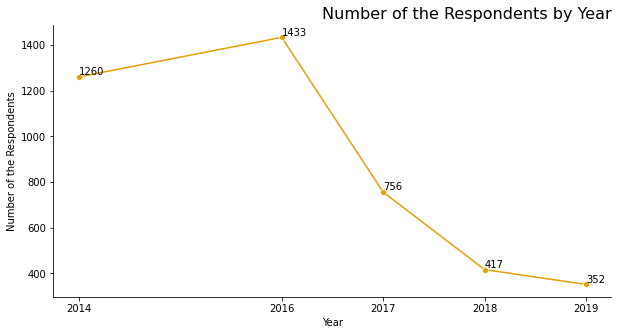

In [13]:
respondents_filtered_df = respondents_df[respondents_df["year"] != 2015]

plt.figure(figsize=(10, 5))
sns.lineplot(
    x="year",
    y="respondents",
    data=respondents_filtered_df,
    marker="o",
    color=custom_palette[0],
)

plt.title("Number of the Respondents by Year", fontsize=16, loc="right")
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.xlabel("Year")
plt.ylabel("Number of the Respondents")
plt.xticks(respondents_filtered_df["year"])

for i in range(len(respondents_filtered_df)):
    plt.text(
        respondents_filtered_df["year"].iloc[i],
        respondents_filtered_df["respondents"].iloc[i],
        str(respondents_filtered_df["respondents"].iloc[i]),
        ha="left",
        va="bottom",
    )

plt.show()

**The number of respondents increased from 2014 to 2016 but then decreased in the following years.**

### 3.2 What are the sociodemographic features of the respondents?

**<font color='blue'>Sociodemographic features are answers to these questions:</font>**

* **What is your age?**
* **What is your gender?**
* **What country do you live in?**
* **If you live in the United States, which state or territory do you live in?**
* **Are you self-employed?**
* **What country do you work in?**
* **What US state or territory do you work in?**
* **What is your race?**

### 3.3 **Searching for any evidence of sampling bias.**

**First of all, data was collected from the OSMI (Open Source Mental Illness) organization's surveys (https://osmihelp.org/research.html) on mental illness in the tech industry. Here are key points to consider:**

* **Participation in the survey is voluntary (<font color='red'>Non-Probability Sampling</font>), meaning individuals who are more aware of mental health issues or personally affected by them may be more inclined to respond. This could result in an overrepresentation of individuals with mental health challenges, inflating prevalence rates.**
* **The survey may disproportionately capture responses from individuals in certain regions or countries (e.g., the USA), influenced by OSMI's reach and language availability. Prevalence rates may not be globally representative and could miss variations in mental health awareness and access to care across cultures.**

## 4. Data Analysis

### 4.1 Main sociodemographic features distributions.

#### <font color='red'>Age</font>

**Checking responses to the question 'What is your age?'.**

In [14]:
distinct_values, count_missing, total_count = count_values(
    mental_df, "What is your age?"
)

answer_text
30    250
29    229
32    227
31    223
28    220
Name: count, dtype: int64

... and 60 more distinct values.

Count of -1 values: 5
Total count of responses: 4218


**A minority of the answers are invalid (I believe people working in the tech industry are between 18 and 75 years of age) or contain missing values ('-1'). These values are replaced with the median.**

In [15]:
age_df = mental_df[mental_df["question_text"] == "What is your age?"].copy()
age_df["answer_text"] = pd.to_numeric(age_df["answer_text"])

median_value = age_df.loc[
    (age_df["answer_text"] >= 18) & (age_df["answer_text"] <= 75), "answer_text"
].median()

age_df.loc[
    (age_df["answer_text"] < 18) | (age_df["answer_text"] > 75), "answer_text"
] = median_value

**Plotting age distribution.**

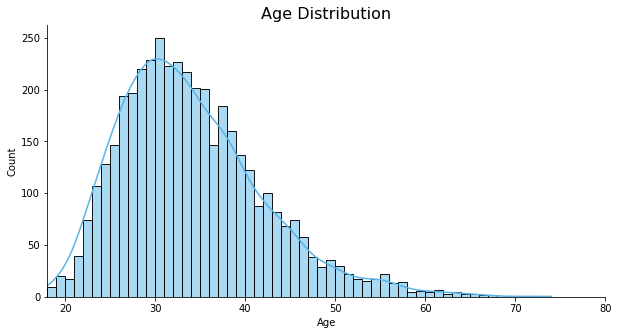

In [16]:
plt.figure(figsize=(10, 5))
sns.histplot(age_df["answer_text"], kde=True, bins=56, color=custom_palette[1])

plt.title("Age Distribution", fontsize=16)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.xlabel("Age")
plt.ylabel("Count")
plt.xlim(left=18, right=80)

plt.show()

**The tech industry is dominated by younger people, reflecting potential challenges for older professionals in the industry.**

#### <font color='red'>Gender</font>

**Checking responses to the question 'What is your gender?'.**

In [17]:
distinct_values, count_missing, total_count = count_values(
    mental_df, "What is your gender?"
)

answer_text
Male      2830
Female     914
male       212
female     110
-1          24
Name: count, dtype: int64

... and 96 more distinct values.

Count of -1 values: 24
Total count of responses: 4218


**All genders other than 'Male' and 'Female', including values such as '-1' (representing possible missing or intentionally undisclosed gender values), now will be grouped into an 'Other' category. This approach ensures the overall distribution remains accurate while maintaining clarity and simplicity in the analysis.**

In [18]:
gender_mapping = {"male": "Male", "female": "Female"}

gender_df = transform_and_aggregate(
    df=mental_df,
    question="What is your gender?",
    column_name="gender",
    mapping=gender_mapping,
)

**Plotting result.**

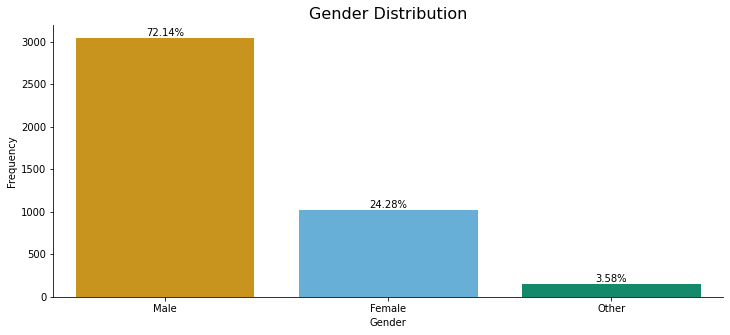

In [19]:
plot_bar_with_percentages(
    gender_df,
    "gender",
    "count",
    "gender",
    "Gender Distribution",
    "Gender",
    "Frequency",
    palette=custom_palette,
)

**The dataset shows a significant skew towards males, reflecting the gender imbalance commonly observed in the tech industry.**

#### <font color='red'>Country of Residence</font>

**Checking responses to the question 'What country do you live in?'.**

In [20]:
distinct_values, count_missing, total_count = count_values(
    mental_df, question_text="What country do you live in?"
)

answer_text
United States of America    1853
United States                751
United Kingdom               482
Canada                       199
Germany                      136
Name: count, dtype: int64

... and 76 more distinct values.

Count of -1 values: 2
Total count of responses: 4218


**All countries other than 'United States', including values such as '-1' (representing potential missing values), now will be be grouped into an 'Other' category. This approach ensures that the overall distribution remains accurate while maintaining clarity and simplicity in the analysis.**

In [21]:
country_mapping = {
    "united states of america": "United States",
    "united states": "United States",
}

country_df = transform_and_aggregate(
    df=mental_df,
    question="What country do you live in?",
    column_name="country",
    mapping=country_mapping,
)

**Plotting result.**

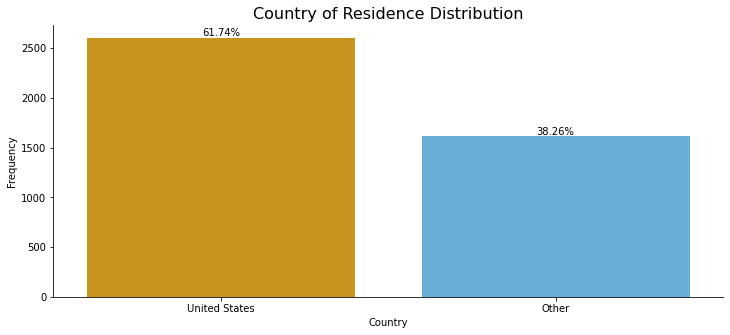

In [22]:
plot_bar_with_percentages(
    country_df,
    "country",
    "count",
    "country",
    "Country of Residence Distribution",
    "Country",
    "Frequency",
    palette=[custom_palette[0], custom_palette[1]],
)

**<font color='blue'>The dataset shows a significant skew towards the United States, this is an important factor to consider when calculating prevalence rates.</font>**

### 4.2 Exploring Relationships Between Variables.

#### <font color='red'>Age vs Self-employment</font>

**Checking responses to the question 'Are you self-employed?'.**

In [23]:
distinct_values, count_missing, total_count = count_values(
    mental_df, question_text="Are you self-employed?"
)

answer_text
0     3550
1      650
-1      18
Name: count, dtype: int64

Count of -1 values: 18
Total count of responses: 4218


**Globally, fewer people are self-employed ('1') compared to those working in traditional employment ('0'). Additionally, a minority of the answers contain missing values ('-1'), which are replaced with 'Yes', 'No', and the mode accordingly.**

In [24]:
self_employment_df = mental_df[
    mental_df["question_text"] == "Are you self-employed?"
].copy()
self_employment_df = self_employment_df[["user_id", "answer_text"]]

self_employment_df.loc[self_employment_df["answer_text"] == "0", "answer_text"] = "No"
self_employment_df.loc[self_employment_df["answer_text"] == "1", "answer_text"] = "Yes"

mode_value = (
    self_employment_df.loc[self_employment_df["answer_text"] != "-1", "answer_text"]
    .mode()
    .iloc[0]
)

self_employment_df.loc[self_employment_df["answer_text"] == "-1", "answer_text"] = (
    mode_value
)

**Merging `age_df` and `self_employment_df` dataframes on `user_id`.**

In [25]:
merged_df = pd.merge(
    age_df[["user_id", "answer_text"]], self_employment_df, on="user_id"
)

merged_df.columns = ["user_id", "age", "self-employed"]

**Plotting boxplots.**

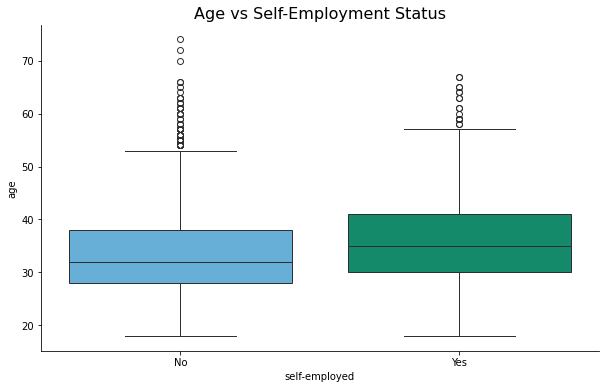

In [26]:
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=merged_df,
    x="self-employed",
    y="age",
    hue="self-employed",
    palette=[custom_palette[1], custom_palette[2]],
)

plt.title("Age vs Self-Employment Status", fontsize=16)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.show()

**Self-employed individuals, on average, are slightly older than those in traditional employment. However, the age distribution is quite similar across both groups, indicating that age does not vary widely between them, despite the presence of more outliers among non-self-employed individuals compared to self-employed individuals.**

#### <font color='red'>Gender vs Current Mental Health Status</font>

**Checking responses to the question 'Do you currently have a mental health disorder?'.**

In [27]:
distinct_values, count_missing, total_count = count_values(
    mental_df, question_text="Do you currently have a mental health disorder?"
)

answer_text
Yes           1237
No             969
Maybe          327
Possibly       301
Don't Know     124
Name: count, dtype: int64

Count of -1 values: 0
Total count of responses: 2958


**Merging `gender_df` and `current_disorder_df` dataframes on `user_id`.**

In [28]:
current_disorder_df = mental_df[
    mental_df["question_text"] == "Do you currently have a mental health disorder?"
].copy()

current_disorder_df = current_disorder_df[["user_id", "answer_text"]]

gender_df = mental_df[mental_df["question_text"] == "What is your gender?"].copy()
gender_df["answer_text"] = gender_df["answer_text"].str.lower()

gender_df.loc[
    (gender_df["answer_text"] != "female") & (gender_df["answer_text"] != "male"),
    "answer_text",
] = "other"

merged_df = pd.merge(
    gender_df[["user_id", "answer_text"]], current_disorder_df, on="user_id"
)

merged_df.columns = ["user_id", "gender", "mental_health_disorder"]

**Plotting heatmap.**

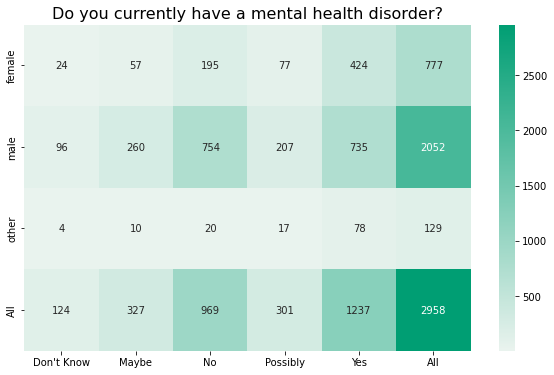

In [29]:
cross_tab = pd.crosstab(
    merged_df["gender"], merged_df["mental_health_disorder"], margins=True
)

custom_cmap = sns.light_palette(custom_palette[2], as_cmap=True)

plt.figure(figsize=(10, 6))
sns.heatmap(cross_tab, annot=True, fmt="d", cmap=custom_cmap)

plt.title("Do you currently have a mental health disorder?", fontsize=16)
plt.xlabel("")
plt.ylabel("")

plt.show()

**Across all genders, there is a notable prevalence of reported mental health disorders, with females reporting a higher proportion than males. However, a large portion of individuals remain uncertain or hesitant to classify themselves.**

### 4.3 Correlation Analysis: Age and Mental Health Disorder.

**Merging the `age_df` and `current_disorder_df` dataframes on `user_id`.**

In [30]:
merged_df = pd.merge(
    age_df[["user_id", "answer_text"]], current_disorder_df, on="user_id"
)

merged_df.columns = ["user_id", "age", "mental_health_disorder"]

**Mapping the ordinal variable to numerical ranks and adding jitter to the ranks.**

In [31]:
rank_mapping = {"Yes": 5, "Maybe": 4, "Possibly": 3, "Don't Know": 2, "No": 1}
merged_df["mental_health_rank"] = merged_df["mental_health_disorder"].map(rank_mapping)

jitter = np.random.normal(0, 0.1, size=len(merged_df))
merged_df["mental_health_rank_jitter"] = merged_df["mental_health_rank"] + jitter

**Plotting scatterplot.**

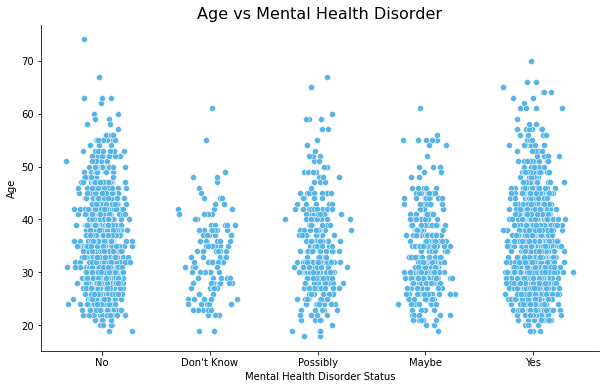

In [32]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x="mental_health_rank_jitter", y="age", data=merged_df, color=custom_palette[1]
)

plt.title("Age vs Mental Health Disorder", fontsize=16)
plt.xlabel("Mental Health Disorder Status")
plt.ylabel("Age")
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.xticks(ticks=range(1, 6), labels=["No", "Don't Know", "Possibly", "Maybe", "Yes"])

plt.show()

**The points are not consistent, suggesting a non-monotonic relationship between the variables. However, Spearman’s Rank Correlation is still calculated, though its result might not fully capture the relationship if it’s truly non-monotonic..**

In [33]:
correlation, p_value = spearmanr(merged_df["mental_health_rank"], merged_df["age"])
print(f"Spearman correlation: {correlation}, P-value: {p_value}")

Spearman correlation: -0.0356336389934729, P-value: 0.052645096547779796


* **A Spearman correlation close to 0 indicates that there is little to no monotonic relationship between the variables. In other words, as age increases, there isn't a clear, consistent trend in the mental health disorder data.**
* **Given the p-value is above 0.05, this result is not statistically significant, so we cannot confidently conclude that age has any effect on the likelihood of having a mental health disorder.**

## 5. Prevalence Rate of Top 3 Mental Conditions in the Tech Industry in the USA.

**Checking responses to the question 'Is your employer primarily a tech company/organization?'.**

In [34]:
distinct_values, count_missing, total_count = count_values(
    mental_df, question_text="Is your employer primarily a tech company/organization?"
)

answer_text
1     2888
0      826
-1     504
Name: count, dtype: int64

Count of -1 values: 504
Total count of responses: 4218


**Excluding records where the employer was not identified as a tech company or organization to focus on the impact of mental health issues within tech companies. Additionally, the United States was chosen as the target country, based on findings during the analysis.**

In [35]:
tech_respondents = mental_df[
    (
        mental_df["question_text"]
        == "Is your employer primarily a tech company/organization?"
    )
    & (mental_df["answer_text"] == "1")
]["user_id"]

us_respondents = mental_df[
    (mental_df["question_text"] == "What country do you live in?")
    & (mental_df["answer_text"].isin(["United States of America", "United States"]))
]["user_id"]

target_respondents = set(us_respondents).intersection(set(tech_respondents))
target_df = mental_df[mental_df["user_id"].isin(target_respondents)]

**Checking responses to the question 'If yes, what condition(s) have you been diagnosed with?'.**

In [36]:
distinct_values, count_missing, total_count = count_values(
    target_df, question_text="If yes, what condition(s) have you been diagnosed with?"
)

answer_text
-1                                                     292
Mood Disorder (Depression, Bipolar Disorder, etc)      187
Anxiety Disorder (Generalized, Social, Phobia, etc)    144
Attention Deficit Hyperactivity Disorder                68
Post-traumatic Stress Disorder                          28
Name: count, dtype: int64

... and 16 more distinct values.

Count of -1 values: 292
Total count of responses: 816


**In this case, a value of '-1' indicates that the respondent does not have any disorder. Additionally, some questions can allow multiple answers, meaning the same user_id may appear more than once for a given question_id. The goal is to calculate the total number of unique respondents and slice the data to assign the top 3 disorders.**

In [37]:
diagnosed_df = target_df[
    target_df["question_text"]
    == "If yes, what condition(s) have you been diagnosed with?"
]

total_respondents = diagnosed_df["user_id"].nunique()
top_disorders = distinct_values.iloc[1:4]

print(f"Total respondents: {total_respondents}")

Total respondents: 540


**It is true that some respondents report having more than one disorder. Calculating the prevalence rate for each top3 disorder.**

In [38]:
prevalence_rates = (top_disorders / total_respondents) * 100

**Calculating the confidence intervals for each disorder.**

In [39]:
conf_intervals = []

for count in top_disorders:
    p = count / total_respondents
    lower, upper = calculate_confidence_interval(p, total_respondents)
    conf_intervals.append((lower * 100, upper * 100))

**Preparing data for plotting.**

In [40]:
plot_data = pd.DataFrame(
    {
        "condition": top_disorders.index,
        "count": top_disorders.values,
        "prevalence_rate": prevalence_rates.values,
        "ci_lower": [ci[0] for ci in conf_intervals],
        "ci_upper": [ci[1] for ci in conf_intervals],
    }
)

**Plotting result.**

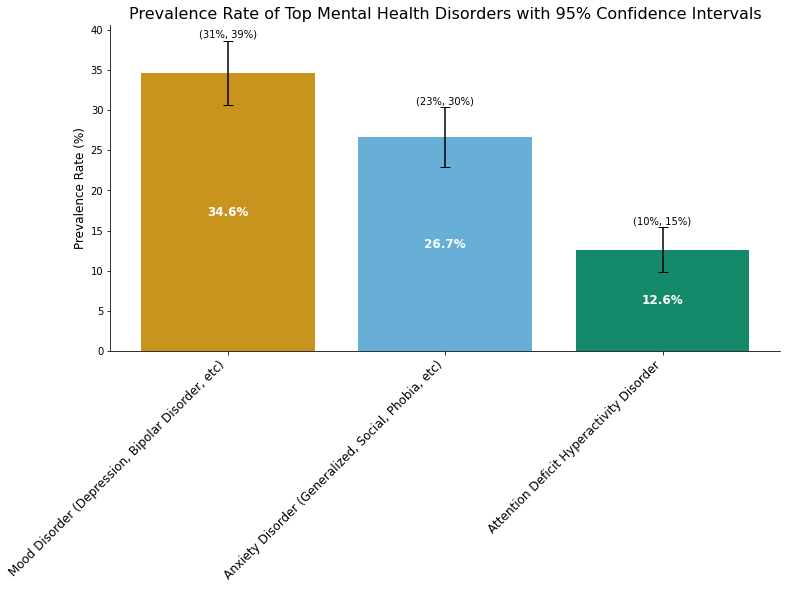

In [41]:
plot_prevalence_with_ci(
    plot_data=plot_data,
    title="Prevalence Rate of Top Mental Health Disorders with 95% Confidence Intervals",
    palette=custom_palette,
)

**The confidence intervals provide a range within which we expect the true prevalence rates of each disorder to lie, based on the sample data.** 
* **Mood Disorder:** The prevalence rate is 34.6%. This means that we are 95% confident that the true prevalence of mood disorders in the population lies between 21% and 39%.
* **Anxiety Disorder:** The prevalence rate is 26.7%. We can be 95% confident that the true prevalence of anxiety disorders in the population is between 23% and 30%.
* **ADHD:** The prevalence rate is 12.6%. This suggests that the true prevalence of ADHD in the population is likely to be between 10% and 15%, with 95% confidence.

## 6. Conclusions

* **Respondent Trends:** The number of respondents increased from 2014 to 2016, but declined in subsequent years.
* **Sociodemographic Biases:** Voluntary participation may lead to an overrepresentation of individuals with mental health challenges, and potential regional biases, particularly from the USA, affecting the global representativeness of the data.
* **Age Distribution:** The tech industry shows a dominance of younger professionals, with a narrow age range (18-75 years), possibly excluding older professionals.
* **Gender and Countries Distributions:** There is a skew towards male respondents and those from the United States.
* **Employment and Age:** Self-employed individuals tend to be slightly older, but the age distribution is quite similar between self-employed and traditionally employed groups.
* **Gender and Mental Health:** Females report higher rates of mental health disorders compared to males, but many respondents remain uncertain about their mental health status.
* **Age and Mental Health:** The relationship between age and mental health disorders appears non-monotonic, with Spearman's correlation indicating no significant relationship.
* **Prevalence of Mental Disorders in the Tech Industry in the USA:** Mood disorders (34.6%), anxiety disorders (26.7%), and ADHD (12.6%) are the most common, with confidence intervals indicating reliable prevalence estimates.


**Some suggestions for improvement:**
* Expand the correlation analysis by including other sociodemographic factors to identify stronger correlations with mental health disorders.
* Perform deeper statistical analysis, like comparing mental health conditions across industries (e.g., tech vs. non-tech).
* Look how specific metrics changed over of the year.